In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data.dataset import random_split

# Data

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import ToTensor, Compose

import os
import random
import datetime
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.dataset import CutOrPad, get_rgb

In [3]:
PASTIS24 = './data/PASTIS24/'
PATH = PASTIS24

In [4]:
files = os.listdir(PATH)
file = random.choice(files)

In [5]:
data = pd.read_pickle(PATH + file)

print(data.keys())
print('Image: ', data['img'].shape)
print('Labels: ', data['labels'].shape)
print('DOY: ', data['doy'].shape)

dict_keys(['img', 'labels', 'doy'])
Image:  (43, 10, 24, 24)
Labels:  (24, 24)
DOY:  (43,)


In [6]:
class PASTIS(Dataset):
    def __init__(self, pastis_path):
        self.pastis_path = pastis_path

        self.file_names = os.listdir(self.pastis_path)

        random.shuffle(self.file_names)

        self.to_cutorpad = CutOrPad()
        # self.to_tiledates = TileDates(24, 24)
        # self.to_unkmask = UnkMask(unk_class=19, ground_truth_target='labels'))



    def __len__(self):
        return len(self.file_names)


    def add_date_channel(self, img, doy):
        img = torch.cat((img, doy), dim=1)
        return img


    def normalize(self, img):
        C = img.shape[1]
        mean = img.mean(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)
        std = img.std(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)

        img = (img - mean) / std

        return img


    def __getitem__(self, idx):
        data = pd.read_pickle(os.path.join(self.pastis_path, self.file_names[idx]))

        data['img'] = data['img'].astype('float32')
        data['img'] = torch.tensor(data['img'])
        data['img'] = self.normalize(data['img'])
        T, C, H, W = data['img'].shape

        data['labels'] = data['labels'].astype('long')
        data['labels'] = torch.tensor(data['labels'])
        # data['labels'] = F.one_hot(data['labels'].long(), num_classes=20)

        data['doy'] = data['doy'].astype('float32')
        data['doy'] = torch.tensor(data['doy'])
        data['doy'] = data['doy'].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        data['doy'] = data['doy'].repeat(1, 1, H, W)

        data['img'] = self.add_date_channel(data['img'], data['doy']) # add DOY to the last channel
        del data['doy'] # Delete DOY

        data = self.to_cutorpad(data) # Pad to Max Sequence Length
        del data['seq_lengths'] # Delete Sequence Length


        return data['img'], data['labels']

In [7]:
data = PASTIS(PATH)
data.__len__()

7675

In [10]:
len(data)

7675

In [12]:
train_set, val_set = random_split(data, [int(.8*len(data)), int(.2*len(data))])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=True)

Text(0.5, 1.0, 'tensor([ 0,  1,  2,  3,  4,  5,  9, 19])')

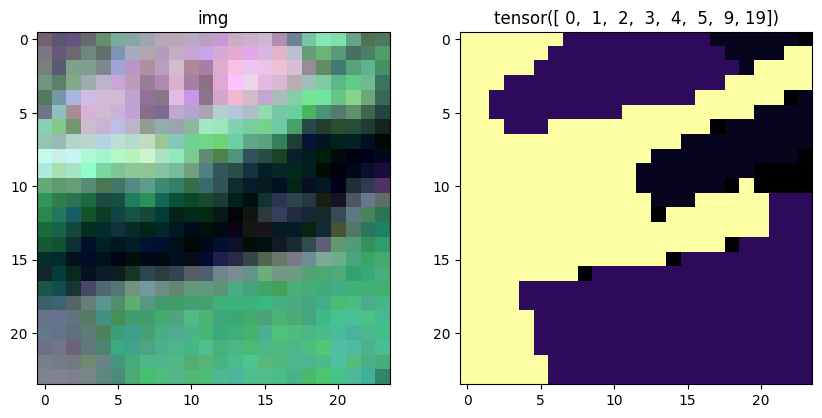

In [13]:
img, label = next(iter(train_loader))

fix, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(get_rgb(img[0][:,:-1,:,:].numpy()))
axes[1].imshow(label[0].numpy(), cmap='inferno')

axes[0].set_title('img')
axes[1].set_title(f'{label.unique()}')

# Model

### Torch Vision Encoder

In [ ]:
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional
from collections import OrderedDict


class MLP(torch.nn.Sequential):
    """This block implements the multi-layer perceptron (MLP) module.

    Args:
        in_channels (int): Number of channels of the input
        hidden_channels (List[int]): List of the hidden channel dimensions
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the linear layer. If ``None`` this layer won't be used. Default: ``None``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the linear layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        inplace (bool, optional): Parameter for the activation layer, which can optionally do the operation in-place.
            Default is ``None``, which uses the respective default values of the ``activation_layer`` and Dropout layer.
        bias (bool): Whether to use bias in the linear layer. Default ``True``
        dropout (float): The probability for the dropout layer. Default: 0.0
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: List[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
    ):
        # The addition of `norm_layer` is inspired from the implementation of TorchMultimodal:
        # https://github.com/facebookresearch/multimodal/blob/5dec8a/torchmultimodal/modules/layers/mlp.py
        params = {} if inplace is None else {"inplace": inplace}

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(torch.nn.Linear(in_dim, hidden_dim, bias=bias))
            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer(**params))
            layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(in_dim, hidden_channels[-1], bias=bias))
        layers.append(torch.nn.Dropout(dropout, **params))

        super().__init__(*layers)





class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )



class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        # self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        # input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))

### DeepSat Encoder

In [14]:
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange



class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)



class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # print(x.shape)
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # print(q.shape, k.shape, v.shape)
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out



class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

### Network

In [15]:
class Segmentation(nn.Module):
    def __init__(self, img_height=24, img_width=24, in_channel=10,
                       patch_size=3, embed_dim=128, max_time=60,
                       num_classes=20, num_head=4, dim_feedforward=2048,
                       num_layers=4, dropoutratio=0.5
                ):
        super().__init__()
        
        self.H = img_height
        self.W = img_width
        self.P = patch_size
        self.C = in_channel
        self.d = embed_dim
        self.T = max_time
        self.K = num_classes

        self.d_model = self.d
        self.num_head = num_head
        self.dim_feedforward = self.d
        self.num_layers = num_layers

        self.N = int(self.H * self.W // self.P**2)
        self.nh = int(self.H / self.P)
        self.nw = int(self.W / self.P)


        '''
        PARAMETERS
        '''
        # Transformer Encoder

        # PyTorch Encoder
        # self.encoderLayer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.num_head, dim_feedforward=self.dim_feedforward)
        # self.encoder = nn.TransformerEncoder(self.encoderLayer, num_layers=self.num_layers)

        # DeepSat Encoder
        self.encoder = Transformer(self.d, self.num_layers, self.num_head, 32, self.d*4, dropoutratio)

        # torchvision Encoder
        # self.encoder = Encoder(seq_length=self.N, num_heads=4, num_layers=4, hidden_dim=self.d, mlp_dim=self.d*4, dropout=0., attention_dropout=0.)

        # Patches
        self.projection = nn.Conv3d(self.C, self.d, kernel_size=(1, self.P, self.P), stride=(1, self.P, self.P))
        '''
        def __init__():
            self.linear = nn.Linear(self.C*self.P**2, self.d)
        def forward():
            x = x.view(B, T, H // P, W // P, C*P**2)
            x = self.linear(x)
        '''

        # Temporal
        self.temporal_emb = nn.Linear(366, self.d)
        self.temporal_cls_token = nn.Parameter(torch.randn(1, self.N, self.K, self.d)) # (N, K, d)
        self.temporal_transformer = self.encoder

        # Spatial
        self.spatial_emb = nn.Parameter(torch.randn(1, self.N, self.d)) # (1, N, d)
        # self.spatial_cls_token = nn.Parameter(torch.randn(1, self.K, self.d)) # (1, K, d)
        self.spatial_transformer = self.encoder

        # Segmentation Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.d),
            nn.Linear(self.d, self.P**2)
            )

        self.dropout = nn.Dropout(p=dropoutratio)


    def forward(self, x):
        '''
        Tekenization

        Convert the images to a sequence of patches
        '''
        x_sits = x[:, :, :-1, :, :] # (B, T, C, H, W) -- > Exclude DOY Channel
        B, T, C, H, W = x_sits.shape # (B, T, C, H, W)
        x_sits = x_sits.reshape(B, C, T, H, W) # (B, C, T, H, W)
        x_sits = self.projection(x_sits) # (B, d, T, nw, nh)
        # x_sits = self.dropout(x_sits)
        x_sits = x_sits.reshape(B, self.d, T, self.nh*self.nw) # (B, d, T, N)
        # x_sits = x_sits + self.pos_emb # (B, d, T, N)  we dont add pos embedding here, cuz we need the pure data for the temporal encoder
        x_sits = x_sits.permute(0,3,2,1) # (B, N, T, d)

        '''
        Temporal Encoding

        (DOY -> One-Hot -> Projection)
        '''
        xt = x[:, :, -1, 0, 0] # (B, T, C, H, W) in the last channel lies the DOY feature
        xt = F.one_hot(xt.to(torch.int64), num_classes=366).to(torch.float32) # (B, T, 366)
        Pt = self.temporal_emb(xt) # (B, T, d) (DOY, one-hot encoded to represent the DOY feature and then encoded to d dimensions)

        '''
        Temporal Encoder: cat(Z+Pt)

        add temporal embeddings (N*K) to the Time Series patches (T)
        '''
        x = x_sits + Pt.unsqueeze(1) # (B, N, T, d)
        # x = self.dropout(x)
        temporal_cls_token = self.temporal_cls_token # (1, N, K, d)
        temporal_cls_token = temporal_cls_token.repeat(B, 1, 1, 1) # (B, N, K, d)
        temporal_cls_token = temporal_cls_token.reshape(B*self.N, self.K, self.d) # (B*N, K, d)
        x = x.reshape(B*self.N, T, self.d) # (B*N, T, d)
        # Temporal Tokens (N*K)
        x = torch.cat([temporal_cls_token, x], dim=1) # (B*N, K+T, d)
        # Temporal Transformer
        x = self.temporal_transformer(x) # (B*N, K+T, d)
        x = x.reshape(B, self.N, self.K + T, self.d) # (B, N, K+T, d)
        x = x[:,:,:self.K,:] # (B, N, K, d)
        x = x.permute(0, 2, 1, 3) # (B, K, N, d)
        x = x.reshape(B*(self.K), self.N, self.d) # (B*K, N, d)

        '''
        Spatial Encoding
        '''
        Ps = self.spatial_emb # (1, N, d)
        x = x + Ps # (B*K, N, d)
        x = self.dropout(x)
        '''
        # For Classification Only
        # spatial_cls_token = self.spatial_cls_token # (1, K, d)
        # spatial_cls_token = spatial_cls_token.unsqueeze(2) # (1, K, 1, d)
        # spatial_cls_token = spatial_cls_token.repeat(B, 1, 1, 1) # (B, K, 1, d)
        # x = torch.cat([spatial_cls_token, x], dim=2) # (B, K, 1+N, d)
        '''
        x = self.spatial_transformer(x) # (B*K, N, d)
        x = x.reshape(B, self.K, self.N, self.d) # (B, K, N, d)
        x = x.permute(0, 2, 1, 3) # (B, N, K, d)

        '''
        Segmentation Head
        '''
        # classes = x[:,:,0,:] # (B, K, d)
        # x = x[:,:,1:,:] # (B, K, N, d)
        # x = self.dropout(x)
        
        x = self.mlp_head(x) # (B, N, K, P*P)

        '''
        Reassemble
        '''
        x = x.permute(0, 2, 3, 1) # (B, N, P*P, K)
        x = x.reshape(B, self.N, self.P, self.P, self.K) # (B, N, P, P, K)
        x = x.reshape(B, self.H, self.W, self.K) # (B, H, W, K)
        # x = x.permute(0, 3, 1, 2) # (B, K, H, W)


        return x

# Training

### Loss Function

In [16]:
class MaskedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, mean=True):
        super(MaskedCrossEntropyLoss, self).__init__()
        self.mean = mean
    
    def forward(self, logits, ground_truth):
        if type(ground_truth) == torch.Tensor:
            target = ground_truth
            mask = None
        elif len(ground_truth) == 1:
            target = ground_truth[0]
            mask = None
        elif len(ground_truth) == 2:
            target, mask = ground_truth
        else:
            raise ValueError("ground_truth parameter for MaskedCrossEntropyLoss is either (target, mask) or (target)")
        
        if mask is not None:
            mask_flat = mask.reshape(-1, 1)  # (N*H*W x 1)
            nclasses = logits.shape[-1]
            logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_logits_flat = logits_flat[mask_flat.repeat(1, nclasses)].view(-1, nclasses)
            target_flat = target.reshape(-1, 1)  # (N*H*W x 1)
            masked_target_flat = target_flat[mask_flat].unsqueeze(dim=-1).to(torch.int64)
        else:
            masked_logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_target_flat = target.reshape(-1, 1).to(torch.int64)  # (N*H*W x 1)
        masked_log_probs_flat = torch.nn.functional.log_softmax(masked_logits_flat, dim=1)  # (N*H*W x Nclasses)
        masked_losses_flat = -torch.gather(masked_log_probs_flat, dim=1, index=masked_target_flat)  # (N*H*W x 1)
        if self.mean:
            return masked_losses_flat.mean()
        return masked_losses_flat

### Train

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data
batch_size = 8
train_set, val_set = random_split(data, [int(.8*len(data)), int(.2*len(data))])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=True)
num_samples = train_loader.__len__()*batch_size

# Model
model = Segmentation(img_width=24, img_height=24, in_channel=10, patch_size=3, embed_dim=128, max_time=60, num_head=4, num_layers=4, num_classes=20)
model.to(device)

num_params = sum([p.numel() for p in model.parameters() if p.requires_grad == True])
print('Number of Parameters: ', num_params)

# Loss
criterion = MaskedCrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()

# Optimizer
# optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
epochs = 100
model.train()

Number of Parameters:  1023881


Segmentation(
  (encoder): Transformer(
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=128, out_features=384, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=128, out_features=512, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=512, out_features=128, bias=True)
              (4): Dropout(p=0.0, inplace=False)
            )
          )
        )
      )
    )
    (norm): LayerNorm((128,

### Trainer

In [20]:
from tqdm import tqdm
for epoch in range(epochs):
  epoch_loss = 0

  t1 = time.time()
  for batch in tqdm(train_loader):
    img, label = batch
    img, label = img.to(device), label.to(device)


    optimizer.zero_grad()
    
    output = model(img)
    
    # print(f'Output shape: {output.shape} | Label shape: {label.shape}')
    # print('Output: ', output[0], 'Label: ', label[0])

    loss = criterion(output, label)
    epoch_loss += loss

    loss.backward()
    optimizer.step()



  if epoch % 10 == 0:
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, f'/workspace/weights/epoch_{epoch}.pt')
  t2 = time.time()

  
    
  print('Epoch: ', epoch, 'Loss: ', (epoch_loss/num_samples_train)*100)


100%|██████████| 768/768 [01:41<00:00,  7.53it/s]


RuntimeError: Parent directory /workspace/weights does not exist.

### Training milad 

In [ ]:
import os
import torch
import logging
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.metrics import Loss
from ignite.contrib.handlers.tensorboard_logger import TensorboardLogger, OutputHandler, WeightsScalarHandler, WeightsHistHandler, GradsScalarHandler
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import LRScheduler
from ignite.metrics import RunningAverage
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [ ]:
from ignite.metrics import Metric
from ignite.metrics.metric import sync_all_reduce, reinit__is_reduced

class CustomAccuracy(Metric):
    def __init__(self, output_transform=lambda x: x):
        super(CustomAccuracy, self).__init__(output_transform=output_transform)

    @reinit__is_reduced
    def reset(self):
        self._num_correct = 0
        self._num_examples = 0

    @reinit__is_reduced
    def update(self, output):
        y_pred, y = output
        predicted_classes = torch.argmax(y_pred, dim=-1)
        correct = (predicted_classes == y).float().sum().item()
        self._num_correct += correct
        self._num_examples += y.numel()

    @sync_all_reduce("_num_correct", "_num_examples")
    def compute(self):
        return self._num_correct / self._num_examples

In [ ]:
model = model  # Your model
train_loader = train_loader  # Your training data loader
val_loader = train_loader  # Your validation data loader
test_loader = train_loader  # Your test data loader
optimizer = optimizer  # Your optimizer
criterion = criterion  # Your loss function

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger('ignite.engine.engine.Engine').setLevel(logging.WARNING)  # <-- Set logging level to WARNING

def setup_directories(log_dir, model_save_dir):
    """Setup directories if they don't exist."""
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

def train_model(model, criterion, optimizer, train_loader, val_loader, max_epochs=100, log_dir='./tb_logs', model_save_dir='./checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Create trainer and evaluator
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(model, metrics={"accuracy": CustomAccuracy(), "loss": Loss(criterion)}, device=device)

    # Tensorboard Logger
    tb_logger = TensorboardLogger(log_dir=log_dir)

    # Attach various logging handlers to Tensorboard for training
    tb_logger.attach(trainer, log_handler=OutputHandler(tag="training", output_transform=lambda loss: {'loss': loss}),
                     event_name=Events.ITERATION_COMPLETED)
    tb_logger.attach(trainer, log_handler=WeightsScalarHandler(model), event_name=Events.ITERATION_COMPLETED)
    tb_logger.attach(trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED)
    tb_logger.attach(trainer, log_handler=GradsScalarHandler(model), event_name=Events.ITERATION_COMPLETED)

    # Learning Rate Scheduler
    lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    scheduler = LRScheduler(lr_scheduler)
    trainer.add_event_handler(Events.ITERATION_COMPLETED, scheduler)

    # Model Checkpointing
    checkpoint_handler = ModelCheckpoint(model_save_dir, 'model', n_saved=3, require_empty=False)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'mymodel': model})

    # Early Stopping
    def score_function(engine):
        val_loss = engine.state.metrics['loss']
        return -val_loss

    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    evaluator.add_event_handler(Events.COMPLETED, handler)

    # Save the first model after the first epoch
    @trainer.on(Events.EPOCH_COMPLETED(once=1))
    def save_first_model(engine):
        epoch = engine.state.epoch
        torch.save(model.state_dict(), os.path.join(model_save_dir, f'first_model_epoch_{epoch}.pth'))

    # Save the last model after each epoch
    @trainer.on(Events.EPOCH_COMPLETED)
    def save_last_model(engine):
        epoch = engine.state.epoch
        torch.save(model.state_dict(), os.path.join(model_save_dir, f'last_model_epoch_{epoch}.pth'))

    # Save the best model based on validation accuracy
    best_accuracy = 0.0
    @trainer.on(Events.EPOCH_COMPLETED)
    def save_best_model(engine):
        evaluator.run(val_loader)
        accuracy = evaluator.state.metrics['accuracy']
        nonlocal best_accuracy
        if accuracy > best_accuracy:
            epoch = engine.state.epoch
            torch.save(model.state_dict(), os.path.join(model_save_dir, f'best_model_epoch_{epoch}.pth'))
            best_accuracy = accuracy

    # Log training loss after each iteration
    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_iteration(engine):
        iteration = (engine.state.iteration - 1) % len(train_loader) + 1
        print(f"Epoch[{engine.state.epoch}] Iteration[{iteration}/{len(train_loader)}] Loss: {engine.state.output:.2f}")

    # Log training and validation results at the end of each epoch
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch_results(engine):
        # Training metrics
        model.eval()  # Set model to evaluation mode
        evaluator.run(train_loader)
        train_metrics = evaluator.state.metrics
        print(f"Training Results - Epoch: {engine.state.epoch} Avg accuracy: {train_metrics['accuracy']:.2f} Avg loss: {train_metrics['loss']:.2f}")
        
        # Validation metrics
        evaluator.run(val_loader)
        val_metrics = evaluator.state.metrics
        print(f"Validation Results - Epoch: {engine.state.epoch} Avg accuracy: {val_metrics['accuracy']:.2f} Avg loss: {val_metrics['loss']:.2f}")

        model.train()  # Set model back to training mode

    # Run the training loop
    trainer.run(train_loader, max_epochs=max_epochs)

    # Close the logger
    tb_logger.close()


In [ ]:

train_model(model, criterion, optimizer, train_loader, val_loader)

### ignite

In [25]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall, ConfusionMatrix
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine, ProgressBar
from utils.accuracy import CustomAccuracy
from tqdm import tqdm



val_metrics = {
    "accuracy": CustomAccuracy(),
    # "precision": Precision(),
    # "recall": Recall(),
    # "confusion_matrix": ConfusionMatrix(num_classes=20),
    "loss": Loss(criterion)
}




def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y = batch[0].to(device), batch[1].to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    # y_pred = torch.argmax(y_pred, dim=3)
    # print(y.shape, y_pred.shape)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_step)



def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        x, y = batch[0].to(device), batch[1].to(device)
        # y = F.one_hot(y, num_classes=20)
        y_pred = model(x)
        # y_pred = F.one_hot(torch.argmax(model(x), dim=3), num_classes=20).astype(int)
        # y_pred = y_pred.permute(0, 3, 1, 2)
        # print(y.shape, y_pred.shape)
        return y_pred, y


evaluator = Engine(validation_step)




# Attach metrics to the evaluators
for name, metric in val_metrics.items():
    metric.attach(evaluator, name)



# How many batches to wait before logging training status
log_interval = 100


@trainer.on(Events.EPOCH_COMPLETED(every=log_interval))
def log_training_loss(engine):
    print(f"Epoch[{engine.state.epoch}], Iter[{engine.state.iteration}] Loss: {engine.state.output:.2f}")




@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")



# Score function to return current value of any metric we defined above in val_metrics
def score_function(engine):
    return engine.state.metrics["accuracy"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "checkpoint",
    n_saved=2,
    filename_prefix="best",
    score_function=score_function,
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer), # helps fetch the trainer's state
)
  
# Save the model after every epoch of val_evaluator is completed
evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})




# Define a Tensorboard logger
tb_logger = TensorboardLogger(log_dir="tb-logger")

# Attach handler to plot trainer's loss every 100 iterations
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.EPOCH_COMPLETED(every=100),
    tag="training",
    output_transform=lambda loss: {"batch_loss": loss},
)

# Attach handler for plotting both evaluators' metrics after every epoch completes
for tag, evaluator in [("training", evaluator), ("validation", evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )



pbar = ProgressBar()
pbar.attach(trainer)

trainer.run(train_loader, max_epochs=epochs)

ValueError: Files ['best_model_2_accuracy=0.5957.pt', 'best_model_2_accuracy=0.5845.pt'] with extension '.pt' are already present in the directory checkpoint. If you want to use this directory anyway, pass `require_empty=False`.

# Evaluation

In [ ]:
img, label = next(iter(val_loader))
model.eval()
output = torch.argmax(model(img.to(device)), dim=3)

fix, axes = plt.subplots(1,3, figsize=(10,10))
axes[0].imshow(get_rgb(img[0][:,:-1,:,:].numpy()))
axes[1].imshow(label[0].numpy(), cmap='inferno')
axes[2].imshow(output[0].cpu().numpy(), cmap='inferno')

axes[0].set_title('img')
axes[1].set_title(f'Label: {label[0].unique().tolist()}')
axes[2].set_title(f'Prediction: {output[0].cpu().unique().tolist()}')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)


checkpoint = torch.load('weights/epoch_80.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']